# import

In [2]:
from __future__ import print_function
import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Dropout,  Flatten
from keras.layers import Reshape
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Flatten
from keras.optimizers import SGD
from keras.datasets import mnist
from keras.layers import Input 
from keras import backend as K
import  matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing import image as kimage

from keras.applications.vgg19 import VGG19
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg19 import preprocess_input
import numpy as np
import tensorflow as tf
from scipy import optimize

#from keras.preprocessing.image import img_to_array
from scipy.optimize import fmin_l_bfgs_b
import time

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# 图片处理和展示

## ipython 自带的

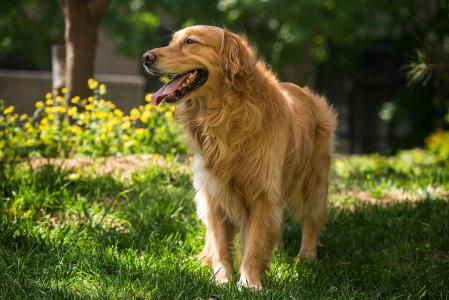

In [10]:
from IPython.display import display, Image, HTML
Image('demo_pic/dog2.jpg')

## skimage包展示图片-优先推荐

(300, 449, 3)
<class 'numpy.ndarray'>


/usr/local/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


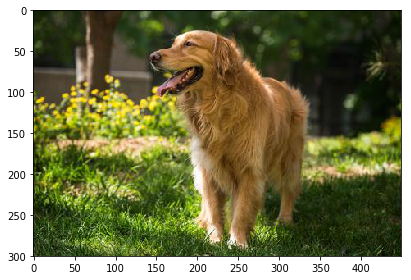

In [124]:
%matplotlib inline
import skimage.io

dog_img = 'demo_pic/dog2.jpg'
img = skimage.io.imread(dog_img)
print(img.shape)
print(type(img))
skimage.io.imshow(img)

## keras 中读取和处理图片

<class 'PIL.Image.Image'>
<class 'numpy.ndarray'>


/usr/local/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


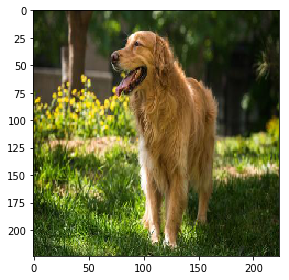

(224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


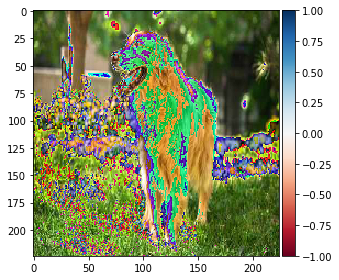

In [118]:

img = kimage.load_img(dog_img, target_size=(224, 224))
print(type(img))
x = kimage.img_to_array(img)
print(type(x))
# 用skimage来展示
tmp = x/255  # 需要归一化到【0，1】。
skimage.io.imshow(tmp)
plt.show() # 为了同时imshow两次

print(x.shape)
x = np.expand_dims(x, axis=0)
print(x.shape)
x = preprocess_input(x) #归一化到了【-1，1】使用：(x-127.5)/127.5
print(x.shape)
skimage.io.imshow(x[0]) # [-1,1]范围，展示的图片很难看

# 简单CNN
来自官方

## 读入数据

In [4]:
batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data('/Users/kunli/work/real_work/mnist.npz')
print(x_train.shape)
print(y_train.shape)
if K.image_data_format() == 'channels_first':
    print('change')
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
print(x_train.shape)

(60000, 28, 28)
(60000,)
(60000, 28, 28, 1)


In [49]:
y_test[:10]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9], dtype=uint8)

In [50]:
K.image_data_format()

'channels_last'

## 数据转换

In [51]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255  # 也可以转换成(x-127.5)/127.5
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes) # one_hot
print(y_test.shape)
#print(y_test[:3])

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
(10000, 10)


In [46]:
y_test[:10]

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

In [53]:
y_test.shape

(10000, 10)

## CNN模型

In [5]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [54]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 198s 3ms/step - loss: 0.2781 - acc: 0.9136 - val_loss: 0.0608 - val_acc: 0.9801
Epoch 2/12
60000/60000 [==============================] - 225s 4ms/step - loss: 0.0914 - acc: 0.9731 - val_loss: 0.0429 - val_acc: 0.9858
Epoch 3/12
60000/60000 [==============================] - 294s 5ms/step - loss: 0.0691 - acc: 0.9806 - val_loss: 0.0329 - val_acc: 0.9886
Epoch 4/12
60000/60000 [==============================] - 194s 3ms/step - loss: 0.0563 - acc: 0.9830 - val_loss: 0.0345 - val_acc: 0.9887
Epoch 5/12
60000/60000 [==============================] - 2397s 40ms/step - loss: 0.0490 - acc: 0.9856 - val_loss: 0.0274 - val_acc: 0.9908
Epoch 6/12
60000/60000 [==============================] - 3649s 61ms/step - loss: 0.0424 - acc: 0.9874 - val_loss: 0.0334 - val_acc: 0.9897
Epoch 7/12
60000/60000 [==============================] - 182s 3ms/step - loss: 0.0395 - acc: 0.9878 - val_loss: 0.028

In [57]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)               1179776   
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
__________

In [143]:
tt = Input(shape=(2,3))
type(tt)

tensorflow.python.framework.ops.Tensor

## 模型保存 &  读取

In [125]:
# 保存权重
model.save_weights('demo_models/cnn.w')

In [126]:
model.save('demo_models/cnn.model')

In [145]:
from keras.models import load_model
x = load_model('demo_models/cnn.model')

/usr/local/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


# load预训练模型

## VGG19

In [144]:
dog_img = 'demo_pic/dog2.jpg'
img = kimage.load_img(dog_img, target_size=(224, 224))
x = kimage.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x) #归一化到了【-1，1】使用：(x-127.5)/127.5

In [165]:
# 模型会自动load下来，存放在 ~/.keras/models 目录下
vgg_model = VGG19(weights='imagenet')

# 使用指定层作为输入和输出
model = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer('block1_pool').output)

In [166]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
Total params: 38,720
Trainable params: 38,720
Non-trainable params: 0
_________________________________________________________________


In [167]:
model.output.shape

TensorShape([Dimension(None), Dimension(112), Dimension(112), Dimension(64)])

In [170]:
from keras.engine.topology import get_source_inputs
tx = get_source_inputs(model.output)
print(len(tx))
tx[0].shape

1


TensorShape([Dimension(None), Dimension(224), Dimension(224), Dimension(3)])

## 获取模型一层的输出

In [176]:
vgg_model = VGG19(weights='imagenet')

tmp_tensor = K.placeholder((1, 244, 244,3))
#tmp_input = Input(tensor=tmp_tensor)
new_output = vgg_model(inputs=tmp_tensor)
new_model = Model(tmp_tensor, new_output)
new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_35 (InputLayer)        (1, 244, 244, 3)          0         
_________________________________________________________________
vgg19 (Model)                multiple                  143667240 
Total params: 143,667,240
Trainable params: 143,667,240
Non-trainable params: 0
_________________________________________________________________


In [82]:
middle_layer_func = K.function([vgg_model.input],
                                  [vgg_model.get_layer('block5_conv2').output])

In [90]:
print(type(vgg_model.input))
print(type(x))

<class 'tensorflow.python.framework.ops.Tensor'>
<class 'numpy.ndarray'>


In [91]:
middle_features = middle_layer_func([x]) # 输入list， 输出为list。
print(type(middle_features))

<class 'list'>


In [111]:
K.eval(K.variable(x))

array([[[[-0.88235295, -0.75686276, -0.96862745],
         [-0.8745098 , -0.7490196 , -0.9607843 ],
         [-0.8745098 , -0.7647059 , -0.9607843 ],
         ...,
         [-0.77254903, -0.6862745 , -0.9372549 ],
         [-0.8666667 , -0.7647059 , -1.        ],
         [-0.8509804 , -0.7490196 , -0.96862745]],

        [[-0.88235295, -0.75686276, -0.96862745],
         [-0.8666667 , -0.7411765 , -0.94509804],
         [-0.8666667 , -0.75686276, -0.9529412 ],
         ...,
         [-0.78039217, -0.69411767, -0.94509804],
         [-0.85882354, -0.75686276, -0.9764706 ],
         [-0.8901961 , -0.7882353 , -1.        ]],

        [[-0.8745098 , -0.7490196 , -0.9607843 ],
         [-0.8666667 , -0.7411765 , -0.94509804],
         [-0.85882354, -0.7490196 , -0.94509804],
         ...,
         [-0.77254903, -0.6862745 , -0.92156863],
         [-0.8352941 , -0.73333335, -0.9529412 ],
         [-0.8980392 , -0.79607844, -1.        ]],

        ...,

        [[-0.2862745 , -0.17647058, -0

## 获取模型所有层的输出
见： http://stackoverflow.org.cn/front/ask/view?ask_id=126879

In [162]:
inp = model.input                                           # input placeholder
outputs = [layer.output for layer in model.layers]          # all layer outputs
functors = [K.function([inp], [out]) for out in outputs]    # evaluation functions

In [163]:
inp.shape

TensorShape([Dimension(None), Dimension(224), Dimension(224), Dimension(3)])

In [38]:
# Testing
layer_outs = [func([x]) for func in functors]

In [39]:
len(layer_outs)

4

In [46]:
layer_outs[0][0].shape

(1, 224, 224, 3)

## mobilenet_v2

In [181]:
# 模型会自动load下来，存放在 ~/.keras/models 目录下
mobile_net = MobileNet(weights='imagenet')

In [183]:
mobile_net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_36 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 226, 226, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (Activation)      (None, 112, 112, 32)      0         
_________________________________________________________________
conv_pad_1 (ZeroPadding2D)   (None, 114, 114, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
__________

### 一个疑问
https://github.com/keras-team/keras/issues/10331

In [184]:
# 读入预测的图片，并转化为模型需要的图片大小
dog_img = 'demo_pic/dog2.jpg'
img = kimage.load_img(dog_img, target_size=(224, 224))
x = kimage.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x) #归一化到了【-1，1】使用：(x-127.5)/127.5
ret = mobile_net.predict(x)

In [4]:
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing import image as kimage
import numpy as np
from keras import backend as K

# load model
mobile_net = MobileNet(weights='imagenet')

# load img
dog_img = 'demo_pic/dog2.jpg'
img = kimage.load_img(dog_img, target_size=(224, 224))
x = kimage.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x) 

# is fast
one_ret = mobile_net.predict(x) 

# is vary slow
tmp_out = mobile_net(inputs=K.variable(x)) # 为什么会非常慢？

# 风格迁移
参考地址：https://github.com/keras-team/keras/blob/master/examples/neural_style_transfer.py

缺点： 速度很慢。
    优化的有：https://arxiv.org/pdf/1612.04337.pdf
    https://arxiv.org/pdf/1703.06868.pdf

In [3]:
class Evaluator(object):

    def __init__(self, eval_loss_and_grads_func):
        self.loss_value = None
        self.grads_values = None
        self.eval_loss_and_grads_func = eval_loss_and_grads_func

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = self.eval_loss_and_grads_func(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values


class NeuralStyleTransfer(object):
    def __init__(self, img_nrows=224, img_ncols=244, iterations=20, model_file=""):
        ''' 图片大小为224 是模型输入shape'''
        self.img_nrows = img_nrows
        self.img_ncols = img_ncols
        self.input_shape = None    #图片输入和输出大小 （img_nrows,img_ncols,3) 

        self.style_weight = 0.5
        self.content_weight = 0.2
        self.total_variation_weight = 0.3
        self.base_image = None
        self.style_image  = None
        self.model_vgg = None
        self.outputs_dict = None
        self.f_outputs = None
        self.iterations = iterations
        # load vgg19模型
        #if model_file == "":
            #self.mobilenet = MobileNet(weights='imagenet')
        #    self.model_vgg = VGG19(weights='imagenet')
        #else:
        #    self.model_vgg = load_model(model_file)
            
    # 帮助函数
    def preprocess_image(self, image_path):
        img = kimage.load_img(image_path, target_size=(self.img_nrows, self.img_ncols))
        img = kimage.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img = preprocess_input(img)
        return img
    
    def deprocess_image(self, x):
        if K.image_data_format() == 'channels_first':
            x = x.reshape((3, self.img_nrows, self.img_ncols))
            x = x.transpose((1, 2, 0))
        else:
            x = x.reshape((self.img_nrows, self.img_ncols, 3))
        # Remove zero-center by mean pixel
        x[:, :, 0] += 103.939
        x[:, :, 1] += 116.779
        x[:, :, 2] += 123.68
        # 'BGR'->'RGB'
        x = x[:, :, ::-1]
        x = np.clip(x, 0, 255).astype('uint8')
        return x
    
    # 损失函数
    def gram_matrix(self, x):
        assert K.ndim(x) == 3
        if K.image_data_format() == 'channels_first':
            features = K.batch_flatten(x)
        else:
            features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
        gram = K.dot(features, K.transpose(features))
        return gram

    def style_loss(self, style, combination):
        assert K.ndim(style) == 3
        assert K.ndim(combination) == 3
        S = self.gram_matrix(style)
        C = self.gram_matrix(combination)
        channels = 3
        size = self.img_nrows * self.img_ncols
        return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

    def content_loss(self, base, combination):
        return K.sum(K.square(combination - base))

    # 此函数用于得到的图片局部平滑
    def total_variation_loss(self, x):
        assert K.ndim(x) == 4
        if K.image_data_format() == 'channels_first':
            a = K.square(x[:, :, :self.img_nrows - 1, :self.img_ncols - 1] - x[:, :, 1:, :self.img_ncols - 1])
            b = K.square(x[:, :, :self.img_nrows - 1, :self.img_ncols - 1] - x[:, :, :self.img_nrows - 1, 1:])
        else:
            a = K.square(x[:, :self.img_nrows - 1, :self.img_ncols - 1, :] - x[:, 1:, :self.img_ncols - 1, :])
            b = K.square(x[:, :self.img_nrows - 1, :self.img_ncols - 1, :] - x[:, :self.img_nrows - 1, 1:, :])
        return K.sum(K.pow(a + b, 1.25))

    
    def total_loss(self):
        loss = K.variable(0)
        """ # 不是tensor格式，而是numpy格式
        middle_layer_func = K.function([self.model_vgg.input],
                                  [self.model_vgg.get_layer('block5_conv2').output])
        style_reference_features = middle_layer_func([self.style_image])[0][0]
        base_image_features = middle_layer_func([self.base_image])[0][0]
        """     
        # 内容损失
        layer_features = self.outputs_dict['block5_conv2']
        base_image_features = layer_features[0, :, :, :]
        combination_features = layer_features[2, :, :, :]
        loss += self.content_weight * self.content_loss(base_image_features,combination_features)

        # style 损失
        feature_layers = ['block1_conv1', 'block2_conv1',
                      'block3_conv1', 'block4_conv1',
                      'block5_conv1']
        for layer_name in feature_layers:
            layer_features = self.outputs_dict[layer_name]
            style_reference_features = layer_features[1, :, :, :]
            combination_features = layer_features[2, :, :, :]
            sl = self.style_loss(style_reference_features, combination_features)
            loss += (self.style_weight / len(feature_layers)) * sl
        
        # 局部平滑损失
        loss += self.total_variation_weight * self.total_variation_loss(self.combination_image)
        
        return loss
    
    def compute_tensor(self, base_image_path, style_reference_image_path):
        # 读入图片
        self.base_image = K.variable(self.preprocess_image(base_image_path))
        self.style_image = K.variable(self.preprocess_image(style_reference_image_path))
        
        # 生成图片，必须用tensor格式，因为需要计算其导数，k.gradient。
        if K.image_data_format() == 'channels_first':
            self.combination_image = K.placeholder((1, 3, self.img_nrows, self.img_ncols))
            self.input_shape = (3,self.img_nrows, self.img_ncols)
        else:
            self.combination_image = K.placeholder((1, self.img_nrows, self.img_ncols, 3))
            self.input_shape = (self.img_nrows, self.img_ncols,3)

        input_tensor = K.concatenate([self.base_image,
                              self.style_image,
                              self.combination_image], axis=0)
        return input_tensor
    
    # 将损失和梯度值，变换为numpy 用于后面的优化
    def eval_loss_and_grads(self, x):
        if K.image_data_format() == 'channels_first':
            x = x.reshape((1, 3, self.img_nrows, self.img_ncols))
        else:
            x = x.reshape((1, self.img_nrows, self.img_ncols, 3))
        outs = self.f_outputs([x])
        loss_value = outs[0]
        if len(outs[1:]) == 1:
            grad_values = outs[1].flatten().astype('float64')
        else:
            grad_values = np.array(outs[1:]).flatten().astype('float64')
        return loss_value, grad_values
    
    def style_transfer(self, base_image_path, style_reference_image_path):
        # 生成tensor
        input_tensor = self.compute_tensor(base_image_path, style_reference_image_path)
        
        # load model。 
        self.model_vgg = VGG19(input_tensor=input_tensor, input_shape=self.input_shape, \
                               weights='imagenet', include_top=False)# 参数include_top=False 时input_shape才有效（不然输入形状必须是 (224, 224, 3)
        
        # 得到每层的输出
        self.outputs_dict = dict([(layer.name, layer.output) for layer in self.model_vgg.layers])

        # 计算loss
        loss = self.total_loss()
        grads = K.gradients(loss, self.combination_image)
        outputs = [loss]
        print(type(grads)) 
        if isinstance(grads, (list, tuple)):
            outputs += grads   # 合并成[loss, grads]
        else:
            outputs.append(grads)
            
        self.f_outputs = K.function([self.combination_image], outputs)
        
        # 
        evaluator = Evaluator(self.eval_loss_and_grads)
        
        x = self.preprocess_image(base_image_path)

        for i in range(self.iterations):
            print('Start of iteration', i)
            start_time = time.time()
            x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
            print('Current loss value:', min_val)
            # save current generated image
            img = self.deprocess_image(x.copy())
            img = kimage.array_to_img(img)
            fname = 'iteration_%d.png' % i
            img.save(fname)
            #kimage.save_img(fname, img) # 竟然不可用？
            end_time = time.time()
            print('Image saved as', fname)
            print('Iteration %d completed in %ds' % (i, end_time - start_time))



In [48]:
transfer =  NeuralStyleTransfer()
transfer.style_transfer('demo_pic/content_1.png','demo_pic/style_1.png')

<class 'list'>
Start of iteration 0
Current loss value: 1184643700.0
Image saved as iteration_0.png
Iteration 0 completed in 133s
Start of iteration 1
Current loss value: 635837950.0
Image saved as iteration_1.png
Iteration 1 completed in 123s
Start of iteration 2
Current loss value: 491153600.0
Image saved as iteration_2.png
Iteration 2 completed in 124s
Start of iteration 3
Current loss value: 431339140.0
Image saved as iteration_3.png
Iteration 3 completed in 129s
Start of iteration 4
Current loss value: 397210880.0
Image saved as iteration_4.png
Iteration 4 completed in 131s
Start of iteration 5
Current loss value: 372085440.0
Image saved as iteration_5.png
Iteration 5 completed in 131s
Start of iteration 6
Current loss value: 355599420.0
Image saved as iteration_6.png
Iteration 6 completed in 139s
Start of iteration 7
Current loss value: 341955520.0
Image saved as iteration_7.png
Iteration 7 completed in 116s
Start of iteration 8
Current loss value: 332528100.0
Image saved as iter

In [ ]:
transfer =  NeuralStyleTransfer(img_nrows=720, img_ncols=500,iterations=10)
transfer.style_transfer('wen/wen1.jpeg','wen/style_people.jpg')

<class 'list'>
Start of iteration 0
Current loss value: 368824320.0
Image saved as iteration_0.png
Iteration 0 completed in 838s
Start of iteration 1


## 风格迁移优化
https://github.com/benbenlijie/style_swap_tensorflow